# Imports

In [279]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

import os

import perms

print(tf.__version__)

2.10.0


# Load training images
Load images from the [assets] folder and scan them into arrays.

In [200]:
# A function to convert an image into a permutation
def image_perm(image, perm):
  q0 = image[0:int(image_height/2), 0:int(image_width/2)]
  q1 = image[0:int(image_height/2), int(image_width/2):image_width]
  q2 = image[int(image_height/2):image_height, 0:int(image_width/2)]
  q3 = image[int(image_height/2):image_height, int(image_width/2):image_width]

  pre_perm = [q0, q1, q2, q3]

  q0 = pre_perm[perm[0]]
  q1 = pre_perm[perm[1]]
  q2 = pre_perm[perm[2]]
  q3 = pre_perm[perm[3]]


  res = np.concatenate((np.concatenate((q0, q1), 1), np.concatenate((q2, q3), 1)), 0)
  print(res.shape)
  return res

# List of all directories of training data
dirs = ["0123", "1032", "1230", "2013", "3102"]
# Path to traning data
path = "../assets/train/"
# First file to analyze '0' is the first file in each directory
file_start = 0

# Number of files in each directory to load
file_count = 1500

# Last file to load in each directory
file_end = file_start + file_count

image_width = 128
image_height = 128

# Pre-allocate a large numpy array to store training data
training_images = np.zeros((file_count * len(dirs), image_width, image_height))

# Store labels for the training images
training_labels = np.zeros(file_count * len(dirs))

# Missing offset (If file fails to open, avoid including empty arrays in the testing set with this offset)
miss = 0

# Iterate through each directory, loading [file_count] images from each into the [training_images] array
for i in range(len(dirs)):
  for j in range(file_start, file_end):
    # Parse a path for the file to load
    in_path = path + dirs[i] + "/" + f'{j:05d}' + ".png"
    try:
      # Graryscale the image to reduce data size given to the machine
      im = ImageOps.grayscale(Image.open(in_path))
    except FileNotFoundError:
      print("File not found:")
      print(in_path)
      miss += 1
      continue
    # Add images to training data
    training_images[i*file_count + j - miss] = np.asarray(im, dtype=np.uint8)/255 # Normalize
    # Add label
    if dirs[i] == "0123":
      # Assign '1' for correct-ordered image
      training_labels[i*file_count + j - miss] = 1
    else:
      # Assign '0' for incorrect-ordered image
      training_labels[i*file_count + j - miss] = 0 

print(miss)
# Trim missing data off of the training data
training_images.resize((file_count * len(dirs) - miss, image_width, image_height))
training_labels.resize((file_count * len(dirs) - miss))

# Convert to unsigned integer
training_labels = training_labels.astype(np.uint8)


File not found:
../assets/train/1032/00000.png
File not found:
../assets/train/1032/00014.png
File not found:
../assets/train/1032/00028.png
File not found:
../assets/train/1032/00048.png
File not found:
../assets/train/1032/00049.png
File not found:
../assets/train/1032/00058.png
File not found:
../assets/train/1032/00059.png
File not found:
../assets/train/1032/00060.png
File not found:
../assets/train/1032/00061.png
File not found:
../assets/train/1032/00062.png
File not found:
../assets/train/1032/00063.png
File not found:
../assets/train/1032/00064.png
File not found:
../assets/train/1032/00065.png
File not found:
../assets/train/1032/00066.png
File not found:
../assets/train/1032/00067.png
File not found:
../assets/train/1032/00070.png
File not found:
../assets/train/1032/00071.png
File not found:
../assets/train/1032/00072.png
File not found:
../assets/train/1032/00073.png
File not found:
../assets/train/1032/00074.png
File not found:
../assets/train/1032/00075.png
File not foun

# Preprocessing

(128, 128)


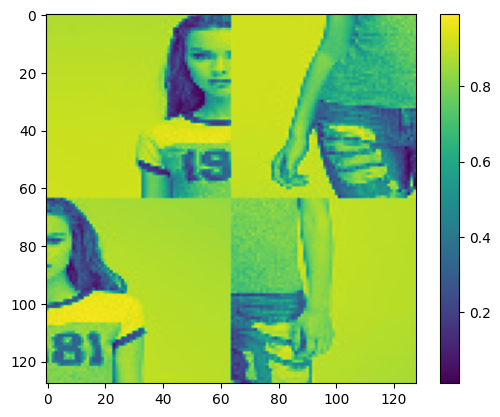

In [297]:


res = image_perm(training_images[0], perms.perms[2])

res.shape
plt.figure()
plt.imshow(res)
plt.colorbar()
plt.grid(False)
plt.show()


# Class names

In [203]:
class_names = ['Incorrect', 'Correct']

# Show additional images

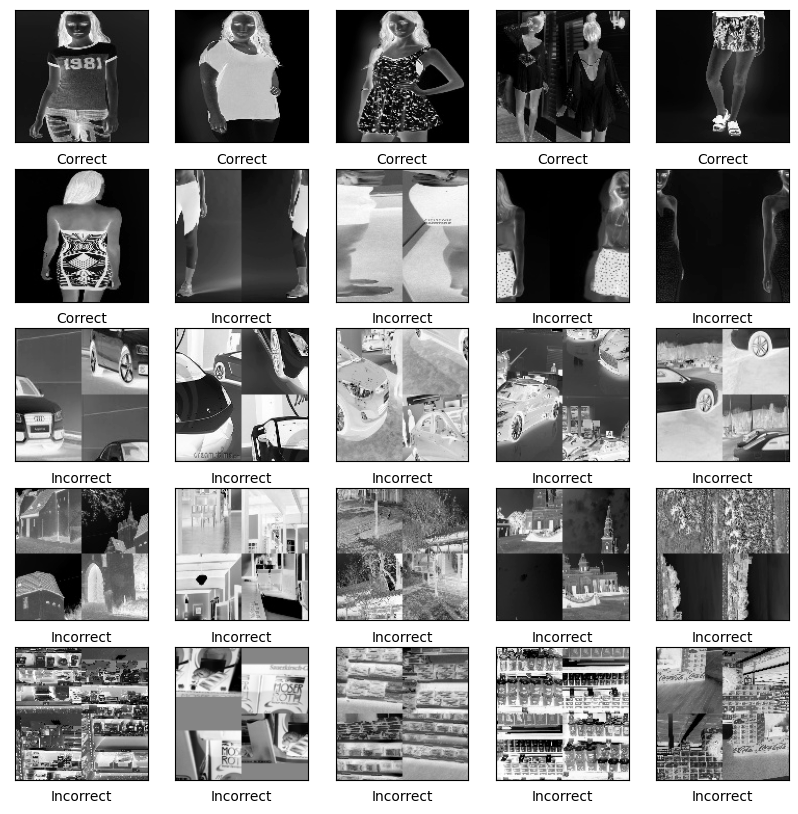

In [207]:
# Modified from https://www.tensorflow.org/tutorials/keras/classification
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training_images[i*(int(len(training_labels)/25))], cmap=plt.cm.binary)
    plt.xlabel(class_names[training_labels[i*(int(len(training_labels)/25))]])
plt.show()

# Setting up the layers

In [252]:
# Modified from https://www.tensorflow.org/tutorials/keras/classification
model = tf.keras.Sequential([
    # Unstacks the pixel rows of the images and lines them end to end 128x128 -> 16,384 pixels
    tf.keras.layers.Flatten(input_shape=(image_width, image_height)),
    # Densely connected nural net with 512 notes
    tf.keras.layers.Dense(512, activation='relu'),
    # Densely connected nural net with 128 notes
    tf.keras.layers.Dense(128, activation='relu'),
    # Fewer nodes
    tf.keras.layers.Dense(10)
])

# Compile stage

In [262]:
model.compile(optimizer='adam', # Determines the way the model is updated
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # Loss function, measures model accuracy
              metrics=['accuracy']) # Show metrics data

# Fit and train model

In [254]:
# Training the model
model.fit(training_images, training_labels, epochs=20)

Epoch 1/20
148/148 [==============================] - 5s 29ms/step - loss: 1.0773 - accuracy: 0.8475
Epoch 2/20
148/148 [==============================] - 4s 29ms/step - loss: 0.3657 - accuracy: 0.8969
Epoch 3/20
148/148 [==============================] - 4s 29ms/step - loss: 0.2464 - accuracy: 0.9206
Epoch 4/20
148/148 [==============================] - 4s 29ms/step - loss: 0.1965 - accuracy: 0.9318
Epoch 5/20
148/148 [==============================] - 4s 30ms/step - loss: 0.1598 - accuracy: 0.9472
Epoch 6/20
148/148 [==============================] - 4s 29ms/step - loss: 0.1374 - accuracy: 0.9542
Epoch 7/20
148/148 [==============================] - 5s 31ms/step - loss: 0.1204 - accuracy: 0.9616
Epoch 8/20
148/148 [==============================] - 4s 29ms/step - loss: 0.1082 - accuracy: 0.9671
Epoch 9/20
148/148 [==============================] - 4s 30ms/step - loss: 0.1066 - accuracy: 0.9647
Epoch 10/20
148/148 [==============================] - 4s 28ms/step - loss: 0.1005 - accura

# Generate testing data

In [237]:
# First file to analyze '0' is the first file in each directory
file_start_test = 0

# Number of files in each directory to load
file_count_test = 500

# Offset from original image set
offset = file_count

# Last file to load in each directory
file_end_test = file_start_test + file_count_test

# Pre-allocate a large numpy array to store training data
testing_images = np.zeros((file_count_test * len(dirs), image_width, image_height))

# Store labels for the training images
testing_labels = np.zeros((file_count_test * len(dirs)))

# Missing offset (If file fails to open, avoid including empty arrays in the testing set with this offset)
miss = 0

# Iterate through each directory, loading [file_count] images from each into the [training_images] array
for i in range(len(dirs)):
  for j in range(0, file_count_test):
    # Parse a path for the file to load
    in_path = path + dirs[i] + "/" + f'{(j + offset):05d}' + ".png"
    try:
      # Graryscale the image to reduce data size given to the machine
      im = ImageOps.grayscale(Image.open(in_path))
    except FileNotFoundError:
      print("File not found:")
      print(in_path)
      miss += 1
      continue
    # Add images to testing data
    testing_images[i*file_count_test + j - miss] = np.asarray(im, dtype=np.uint8)/255 # Normalize
    # Add label
    if dirs[i] == "0123":
      # Assign '1' for correct-ordered image
      testing_labels[i*file_count_test + j - miss] = 1
    else:
      # Assign '0' for incorrect-ordered image
      testing_labels[i*file_count_test + j - miss] = 0 

print(miss)
# Trim missing data off of the training data
testing_images.resize((file_count_test * len(dirs) - miss, image_width, image_height))
testing_labels.resize((file_count_test * len(dirs) - miss))

# Convert to unsigned integer
testing_labels = testing_labels.astype(np.uint8)


File not found:
../assets/train/1032/01008.png
File not found:
../assets/train/1032/01009.png
File not found:
../assets/train/1032/01018.png
File not found:
../assets/train/1032/01019.png
File not found:
../assets/train/1032/01020.png
File not found:
../assets/train/1032/01021.png
File not found:
../assets/train/1032/01022.png
File not found:
../assets/train/1032/01023.png
File not found:
../assets/train/1032/01024.png
File not found:
../assets/train/1032/01025.png
File not found:
../assets/train/1032/01026.png
File not found:
../assets/train/1032/01027.png
File not found:
../assets/train/1032/01030.png
File not found:
../assets/train/1032/01031.png
File not found:
../assets/train/1032/01032.png
File not found:
../assets/train/1032/01033.png
File not found:
../assets/train/1032/01034.png
File not found:
../assets/train/1032/01035.png
File not found:
../assets/train/1032/01036.png
File not found:
../assets/train/1032/01037.png
File not found:
../assets/train/1032/01040.png
File not foun

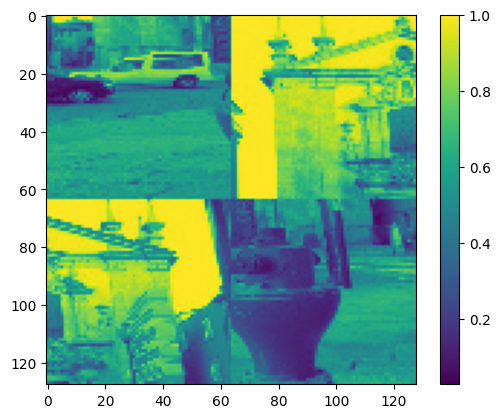

(128, 128)

In [273]:
# Plotting to see the data
plt.figure()
plt.imshow(testing_images[1501])
plt.colorbar()
plt.grid(False)
plt.show()
training_images.shape
type(training_labels)
training_images[1].shape

# Evaluate Test Cases

In [257]:
test_loss, test_acc = model.evaluate(testing_images,  testing_labels, verbose=2)

print('\nTest accuracy:', test_acc)

74/74 - 0s - loss: 0.2145 - accuracy: 0.9272 - 488ms/epoch - 7ms/step

Test accuracy: 0.927172064781189


In [ ]:

checkpoint_file = os.path.dirname("../output/training_checkpoint.ckpt")

# Create a callback that saves the model's weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_file, save_weights_only=True, verbose=2)

# Make Predictions

In [240]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(testing_images)

print("Prediction: {:d}".format(np.argmax(predictions[0])))
print("Reality: {:d}".format(testing_labels[0]))

74/74 [==============================] - 0s 3ms/step
Prediction: 1
Reality: 1


# Plotting results

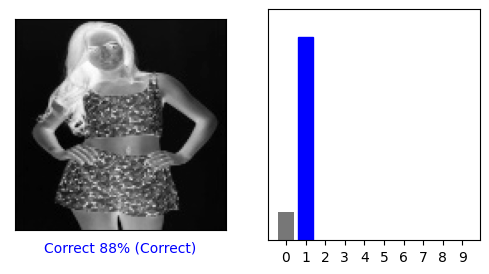

In [258]:
# Taken from https://www.tensorflow.org/tutorials/keras/classification
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

i = 1
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], testing_labels, testing_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  testing_labels)
plt.show()

Plot the first X test images, their predicted labels, and the true labels.  
Color correct predictions in blue and incorrect predictions in red.

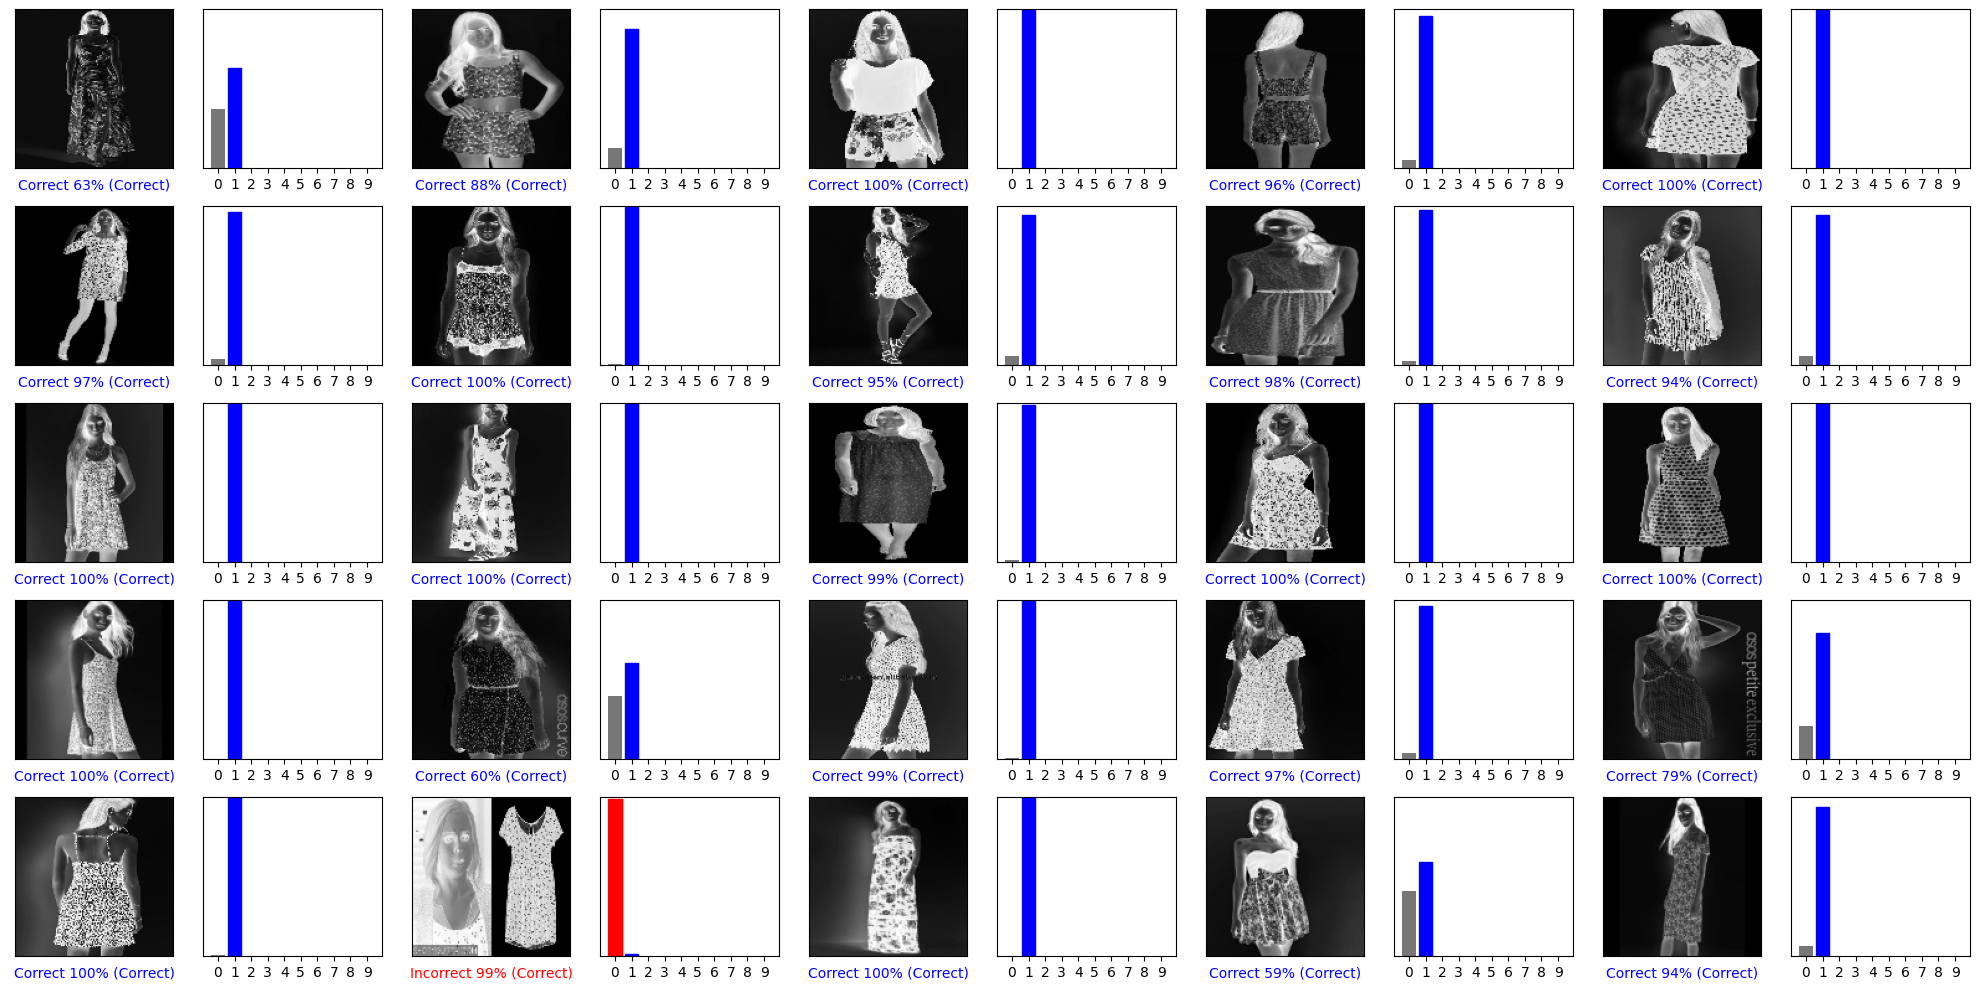

In [259]:
# Modified from https://www.tensorflow.org/tutorials/keras/classification
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], testing_labels, testing_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], testing_labels)
plt.tight_layout()
plt.show()

Using the trained model

(128, 128)
(1, 128, 128)
1/1 [==============================] - 0s 23ms/step
[[7.4363284e-06 9.9999261e-01 3.7231130e-30 1.7715037e-27 2.4674256e-23
  1.3928291e-23 2.5692540e-29 3.7982079e-24 4.4395963e-21 5.4914577e-23]]


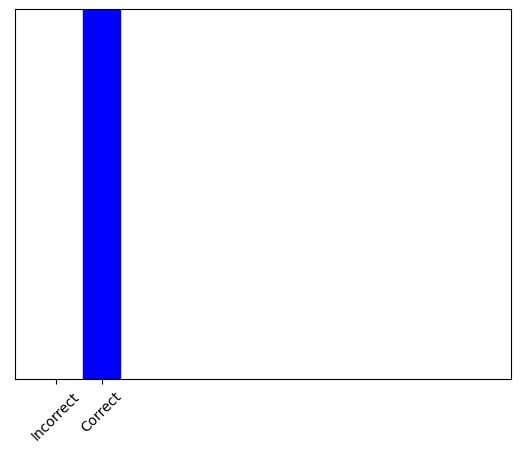

In [260]:
# Grab an image from the test dataset.
img = testing_images[1]

print(img.shape)

# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

# Now predict the correct label for this image:

predictions_single = probability_model.predict(img)

print(predictions_single)

plot_value_array(1, predictions_single[0], testing_labels)
_ = plt.xticks(range(2), class_names, rotation=45)
np.argmax(predictions_single[0])
plt.show()

# Saving the trained model